# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [127]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [128]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [129]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [130]:
import torch

import numpy as np

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for a days in period 2011-01-01 to 2019-12-31 (9 years);

In [131]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [132]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2019-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

10
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (22330, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265023,576145,ABEV3.SA,0
1,2011-01-03,31.500000,31.799999,31.379999,13.565923,3313400,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.708650,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.446303,10014663,ITUB4.SA,0
4,2011-01-03,9.264964,9.492898,9.264964,7.048940,3320493,LREN3.SA,0
...,...,...,...,...,...,...,...,...
22325,2019-12-30,30.549999,30.709999,30.150000,11.107358,22111600,PETR4.SA,0
22326,2019-12-30,6.780000,6.832000,6.570000,6.601397,8933500,PRIO3.SA,0
22327,2019-12-30,47.959999,48.290001,47.299999,44.469746,2701600,RENT3.SA,0
22328,2019-12-30,53.650002,53.860001,53.200001,37.320980,11928100,VALE3.SA,0


In [133]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2233,2233,2233,2233,2233,2233,2233
BBAS3.SA,2233,2233,2233,2233,2233,2233,2233
BBDC4.SA,2233,2233,2233,2233,2233,2233,2233
ITUB4.SA,2233,2233,2233,2233,2233,2233,2233
LREN3.SA,2233,2233,2233,2233,2233,2233,2233
PETR4.SA,2233,2233,2233,2233,2233,2233,2233
PRIO3.SA,2233,2233,2233,2233,2233,2233,2233
RENT3.SA,2233,2233,2233,2233,2233,2233,2233
VALE3.SA,2233,2233,2233,2233,2233,2233,2233


### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [134]:
df_portfolio = portfolio_raw_df[["date", "tic", "close", "high", "low"]]

environment = PortfolioOptimizationEnv(
        df_portfolio,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"]
    )

Normalizing ['close', 'high', 'low'] by previous time...


### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [135]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 4,
    "time_window": 50,
    "device": device
}

model = DRLAgent(environment).get_model("pg", model_kwargs, policy_kwargs)

### Train Model

In [136]:
DRLAgent.train_model(model, episodes=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 361474.125
Final accumulative portfolio value: 3.61474125
Maximum DrawDown: -0.44278663937515705
Sharpe ratio: 0.7851840332671329


  5%|▌         | 1/20 [00:10<03:22, 10.65s/it]

Initial portfolio value:100000
Final portfolio value: 367367.75
Final accumulative portfolio value: 3.6736775
Maximum DrawDown: -0.44544702041693773
Sharpe ratio: 0.7889937808125205


 10%|█         | 2/20 [00:21<03:11, 10.64s/it]

Initial portfolio value:100000
Final portfolio value: 341392.1875
Final accumulative portfolio value: 3.413921875
Maximum DrawDown: -0.40833481343659395
Sharpe ratio: 0.7853202449980996


 15%|█▌        | 3/20 [00:31<03:00, 10.64s/it]

Initial portfolio value:100000
Final portfolio value: 407335.0
Final accumulative portfolio value: 4.07335
Maximum DrawDown: -0.46804438206034515
Sharpe ratio: 0.8067679859324299


 20%|██        | 4/20 [00:42<02:50, 10.66s/it]

Initial portfolio value:100000
Final portfolio value: 420579.9375
Final accumulative portfolio value: 4.205799375
Maximum DrawDown: -0.469598046340988
Sharpe ratio: 0.8051605373339927


 25%|██▌       | 5/20 [00:53<02:39, 10.61s/it]

Initial portfolio value:100000
Final portfolio value: 453810.21875
Final accumulative portfolio value: 4.5381021875
Maximum DrawDown: -0.4524471342004611
Sharpe ratio: 0.827235064234536


 30%|███       | 6/20 [01:03<02:27, 10.53s/it]

Initial portfolio value:100000
Final portfolio value: 561952.375
Final accumulative portfolio value: 5.61952375
Maximum DrawDown: -0.47880184779386326
Sharpe ratio: 0.8551097402398795


 35%|███▌      | 7/20 [01:13<02:16, 10.49s/it]

Initial portfolio value:100000
Final portfolio value: 604649.5
Final accumulative portfolio value: 6.046495
Maximum DrawDown: -0.5322350966854077
Sharpe ratio: 0.7896393741372305


 40%|████      | 8/20 [01:24<02:05, 10.46s/it]

Initial portfolio value:100000
Final portfolio value: 577075.4375
Final accumulative portfolio value: 5.770754375
Maximum DrawDown: -0.5981585577705477
Sharpe ratio: 0.6958970690891116


 45%|████▌     | 9/20 [01:34<01:55, 10.48s/it]

Initial portfolio value:100000
Final portfolio value: 599269.125
Final accumulative portfolio value: 5.99269125
Maximum DrawDown: -0.6529561182875228
Sharpe ratio: 0.6859310166769742


 50%|█████     | 10/20 [01:45<01:44, 10.49s/it]

Initial portfolio value:100000
Final portfolio value: 708887.375
Final accumulative portfolio value: 7.08887375
Maximum DrawDown: -0.6771446995966863
Sharpe ratio: 0.7210440705113376


 55%|█████▌    | 11/20 [01:55<01:34, 10.48s/it]

Initial portfolio value:100000
Final portfolio value: 865635.3125
Final accumulative portfolio value: 8.656353125
Maximum DrawDown: -0.681352361247958
Sharpe ratio: 0.7630764231791436


 60%|██████    | 12/20 [02:06<01:23, 10.47s/it]

Initial portfolio value:100000
Final portfolio value: 973545.25
Final accumulative portfolio value: 9.7354525
Maximum DrawDown: -0.6725992234520531
Sharpe ratio: 0.7939690978360787


 65%|██████▌   | 13/20 [02:17<01:13, 10.57s/it]

Initial portfolio value:100000
Final portfolio value: 1138418.125
Final accumulative portfolio value: 11.38418125
Maximum DrawDown: -0.6711483054281047
Sharpe ratio: 0.8222353508533622


 70%|███████   | 14/20 [02:27<01:03, 10.60s/it]

Initial portfolio value:100000
Final portfolio value: 1402175.5
Final accumulative portfolio value: 14.021755
Maximum DrawDown: -0.662336537704288
Sharpe ratio: 0.86537519568219


 75%|███████▌  | 15/20 [02:38<00:52, 10.55s/it]

Initial portfolio value:100000
Final portfolio value: 1698154.375
Final accumulative portfolio value: 16.98154375
Maximum DrawDown: -0.6535264151004916
Sharpe ratio: 0.9058785622283346


 80%|████████  | 16/20 [02:48<00:42, 10.50s/it]

Initial portfolio value:100000
Final portfolio value: 2016288.25
Final accumulative portfolio value: 20.1628825
Maximum DrawDown: -0.6440322262060848
Sharpe ratio: 0.9428484491387145


 85%|████████▌ | 17/20 [02:58<00:31, 10.48s/it]

Initial portfolio value:100000
Final portfolio value: 2346726.5
Final accumulative portfolio value: 23.467265
Maximum DrawDown: -0.634284880387107
Sharpe ratio: 0.9759229657591402


 90%|█████████ | 18/20 [03:09<00:20, 10.43s/it]

Initial portfolio value:100000
Final portfolio value: 2695615.75
Final accumulative portfolio value: 26.9561575
Maximum DrawDown: -0.6263110274122448
Sharpe ratio: 1.0062827959000722


 95%|█████████▌| 19/20 [03:19<00:10, 10.43s/it]

Initial portfolio value:100000
Final portfolio value: 3077908.25
Final accumulative portfolio value: 30.7790825
Maximum DrawDown: -0.620180266358566
Sharpe ratio: 1.0358328134696104


100%|██████████| 20/20 [03:30<00:00, 10.50s/it]


### Save Model

In [137]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Define test period
In this work, we are going to use three annual test periods: the year of 2020, 2021 and 2022. To get data from Yahoo Finance, we do just like in the training data.

In [138]:
portfolio_2020_raw_df = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2021_raw_df = YahooDownloader(start_date = '2021-01-01',
                                end_date = '2021-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_2022_raw_df = YahooDownloader(start_date = '2022-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (2480, 8)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*

In [139]:
portfolio_2020_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,248,248,248,248,248,248,248
BBAS3.SA,248,248,248,248,248,248,248
BBDC4.SA,248,248,248,248,248,248,248
ITUB4.SA,248,248,248,248,248,248,248
LREN3.SA,248,248,248,248,248,248,248
PETR4.SA,248,248,248,248,248,248,248
PRIO3.SA,248,248,248,248,248,248,248
RENT3.SA,248,248,248,248,248,248,248
VALE3.SA,248,248,248,248,248,248,248


In [140]:
portfolio_2021_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,247,247,247,247,247,247,247
BBAS3.SA,247,247,247,247,247,247,247
BBDC4.SA,247,247,247,247,247,247,247
ITUB4.SA,247,247,247,247,247,247,247
LREN3.SA,247,247,247,247,247,247,247
PETR4.SA,247,247,247,247,247,247,247
PRIO3.SA,247,247,247,247,247,247,247
RENT3.SA,247,247,247,247,247,247,247
VALE3.SA,247,247,247,247,247,247,247


In [141]:
portfolio_2022_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,250,250,250,250,250,250,250
BBAS3.SA,250,250,250,250,250,250,250
BBDC4.SA,250,250,250,250,250,250,250
ITUB4.SA,250,250,250,250,250,250,250
LREN3.SA,250,250,250,250,250,250,250
PETR4.SA,250,250,250,250,250,250,250
PRIO3.SA,250,250,250,250,250,250,250
RENT3.SA,250,250,250,250,250,250,250
VALE3.SA,250,250,250,250,250,250,250


### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [142]:
df_portfolio_2020 = portfolio_2020_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2021 = portfolio_2021_raw_df[["date", "tic", "close", "high", "low"]]
df_portfolio_2022 = portfolio_2022_raw_df[["date", "tic", "close", "high", "low"]]

environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"]
)

Normalizing ['close', 'high', 'low'] by previous time...


Normalizing ['close', 'high', 'low'] by previous time...
Normalizing ['close', 'high', 'low'] by previous time...


### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [143]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(k_size= 4, time_window= 50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 104272.4921875
Final accumulative portfolio value: 1.042724921875
Maximum DrawDown: -0.3134186860319077
Sharpe ratio: 0.36180776300706646
Initial portfolio value:100000
Final portfolio value: 42020.9765625
Final accumulative portfolio value: 0.420209765625
Maximum DrawDown: -0.5931160156249999
Sharpe ratio: -3.141339365788307
Initial portfolio value:100000
Final portfolio value: 52142.08203125
Final accumulative portfolio value: 0.5214208203125
Maximum DrawDown: -0.5175579482110072
Sharpe ratio: -2.195587992293611


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [144]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 403056.28125
Final accumulative portfolio value: 4.0305628125
Maximum DrawDown: -0.47875244091762803
Sharpe ratio: 0.7853090877067095
Initial portfolio value:100000
Final portfolio value: 171126.8125
Final accumulative portfolio value: 1.711268125
Maximum DrawDown: -0.250801953125
Sharpe ratio: 1.712443490118881
Initial portfolio value:100000
Final portfolio value: 95723.921875
Final accumulative portfolio value: 0.95723921875
Maximum DrawDown: -0.17293185561981794
Sharpe ratio: -0.1558444284474649
Initial portfolio value:100000
Final portfolio value: 114157.5
Final accumulative portfolio value: 1.141575
Maximum DrawDown: -0.16239865532322129
Sharpe ratio: 0.8449068899613046


### Plot graphics

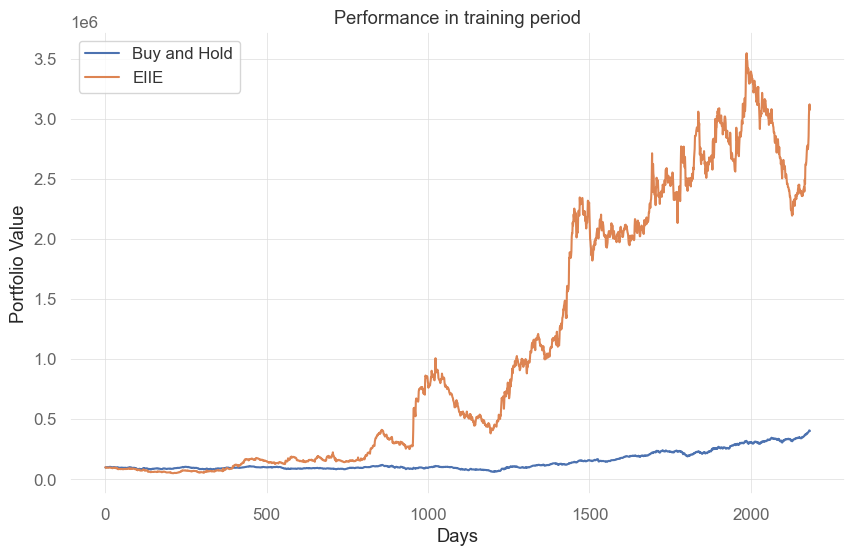

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

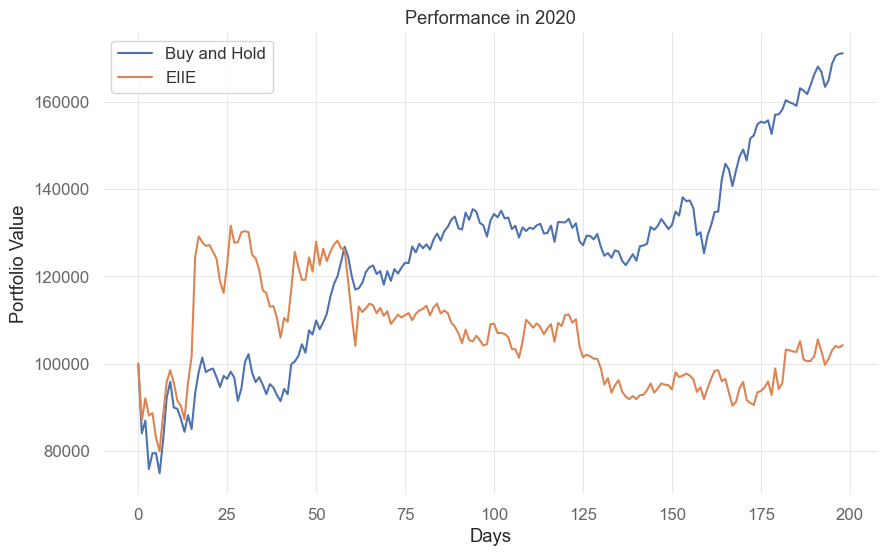

In [146]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

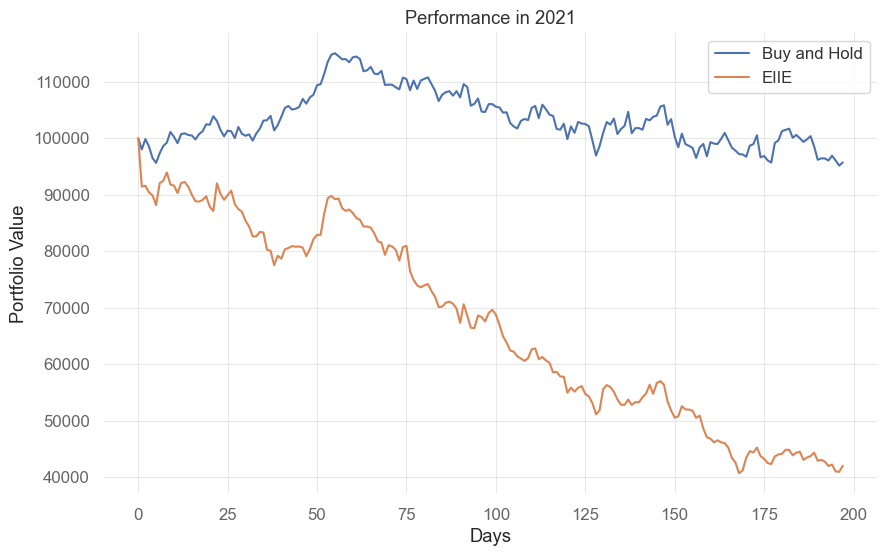

In [147]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

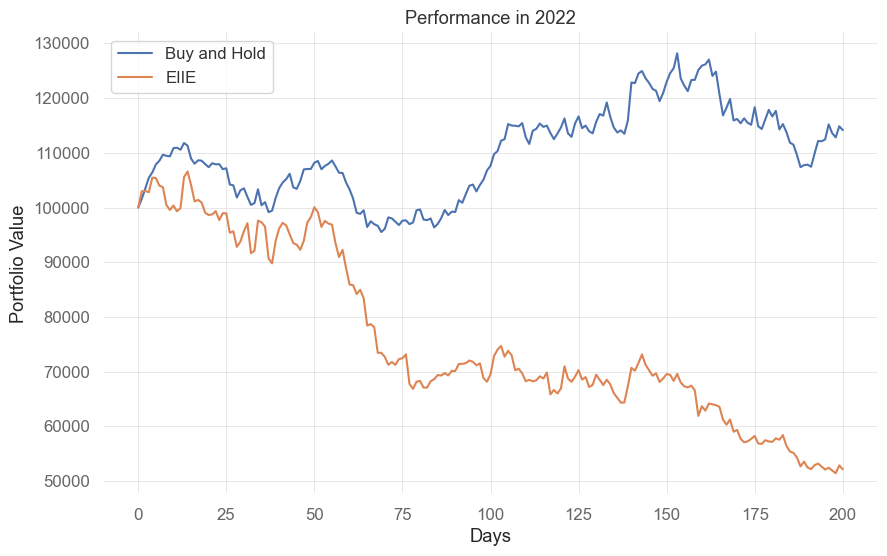

In [148]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is clearly overfitting, since it achieves great results in training period but is mediocre in testing periods. This is a common problem in this policy gradient algorithm. To deal with this, you can change the hyperparameters.